In [1]:
# SEM GPU é muito mais rápido e dá menos erro
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time

log_file = open("output-unet.log","w")

def print_log(*args):
    line = " ".join([str(a) for a in args])
    log_file.write(line+"\n")
    print(line)

training_size:  19 validation_size:  1
epoch completed
shape of the batch (10, 256, 256, 3) (10, 256, 256)
Number of images in the batch:  10


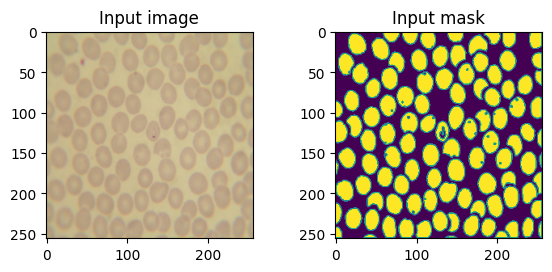

In [3]:
#data generator class
class DataGen(keras.utils.Sequence):
    def __init__(self, train_ids, train_path, batch_size=10, image_size=256, mask_size=None):
        self.ids = train_ids;
        self.path = train_path;
        self.batch_size = batch_size;
        self.image_size = image_size;
        self.mask_size = image_size
        if mask_size != None:
            self.mask_size = mask_size
        
        self.on_epoch_end();
        
    def __load__(self, id_name):
        #defining path for the training data set
        
        id_name_mask = id_name.replace(".JPG",".png").replace(".jpg",".png")
        

        image_path = os.path.join(self.path, "images", id_name);
        mask_path = os.path.join(self.path, "masks", id_name_mask); #mascaras estao em .png
        
        # reading the image from dataset
        ## Reading Image
        image = cv2.imread(image_path); #reading image to image vaiable
        image = cv2.resize(image, (self.image_size, self.image_size));
        mask = cv2.imread(mask_path, 0); #mask image of same size with all zeros
        mask = cv2.resize(mask, (self.image_size ,self.mask_size));
        #mask = np.expand_dims(mask, axis=-1);
        #image normalisation
        image = image / 255.0;
        #mask = mask / 255.0;
        
        mask[mask <= 50] = 0
        mask[np.logical_and(mask > 50, mask < 200)] = 1
        mask[mask >= 200] = 2
        
        return image, mask;
    
    def __getitem__(self, index): #index : batch no.
        
        if(index+1)*self.batch_size > len(self.ids): # redining last batch size
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size] #list of 10 image ids
        
        image = [] #collection of 10 images
        mask  = [] #collection of 10 masks
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name);
            image.append(_img);
            mask.append(_mask);
            
        image = np.array(image);
        mask  = np.array(mask);
        
        return image, mask; #return array of 10 images and 10 masks
    
    #for printing the statistics of the function
    def on_epoch_end(self):
        print_log("epoch completed");
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)));#length of the epoch as length of generation DataGen obj
    
BATCH_SIZE = 10
image_size = 512
mask_size  = None
NUM_EPOCHS = 10
TRAIN_LENGTH = 30
VAL_SUBSPLITS = 5
TEST_LENGTH = 30

train_path = "./data-1024x1024-border"; #address of the dataset
train_ids = os.listdir(train_path + "/images")
val_data_size = 1; #size of set of images used for the validation 
valid_ids = train_ids[:val_data_size]; # list of image ids used for validation of result 0 to 9
train_ids = train_ids[val_data_size:]; #list of image ids used for training dataset
print_log("training_size: ", len(train_ids), "validation_size: ", len(valid_ids))

#making generator object
gen = DataGen(train_ids, train_path, BATCH_SIZE, image_size, mask_size=mask_size);

#Analysing sample of the dataset from data generator
#getting image_set data from dataset
x, y = gen.__getitem__(0); # self = gen and index = 0 each item is a set of 8 images
print_log("shape of the batch", x.shape, y.shape);
print_log("Number of images in the batch: ", len(x));

#display of the sample of the data zeroth image
fig = plt.figure();
fig.subplots_adjust(hspace=0.4, wspace=0.4); #reserving height above plot and space between plots
ax = fig.add_subplot(1, 2, 1); #figure of 1 row 2 columns and 1st image
x1 = (x[2]*255).astype(np.uint8);
x1 = cv2.cvtColor(x1, cv2.COLOR_BGR2RGB);
ax.imshow(x1);
plt.title("Input image");

ax = fig.add_subplot(1, 2, 2); #2nd image plot
ax.imshow(y[2]);
plt.title("Input mask");

In [5]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x

def build_unet_model(input_size=(128,128,3)):
    # inputs
    inputs = layers.Input(shape=input_size)
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)
    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model


unet_model = build_unet_model(input_size = (512,512,3))

In [6]:
save_period = 50
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=BATCH_SIZE);
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=BATCH_SIZE);
print_log("total training batches: ", len(train_gen));
print_log("total validaton batches: ", len(valid_gen));
STEPS_PER_EPOCH = len(train_ids)//BATCH_SIZE;
VALIDATION_STEPS = len(valid_ids)//BATCH_SIZE;
print_log("image_size:", image_size)
print_log("epochs:",NUM_EPOCHS)
print_log("save_period:",save_period)
versao = 1

_fileName = "./unet2-s%d-e%d-v%d-tf241.h5"
filename = _fileName % (image_size, NUM_EPOCHS, versao)

print_log("filename:",filename)

epoch completed
epoch completed
total training batches:  2
total validaton batches:  1
image_size: 256
epochs: 10
filename: ./unet2-s256-e10-v1-tf241.h5


In [7]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath="unet2-checkpoint.h5", 
        verbose=1, 
        save_weights_only=True,
        save_freq=save_period*STEPS_PER_EPOCH)

ini = time.time()

model_history = unet_model.fit(train_gen,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=valid_gen,
                              callbacks=[cp_callback])


fim = time.time()

print_log("Tempo:", fim-ini)

print_log("Horas:", (fim-ini)/60/60)
print_log(filename)
unet_model.save(filename)

Epoch 1/10
1/1 [==============================] - 10s 10s/step - loss: 1.1720 - accuracy: 0.3766
epoch completed
Epoch 2/10
1/1 [==============================] - 9s 9s/step - loss: 4.2240 - accuracy: 0.4150
epoch completed
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 1.0417 - accuracy: 0.4218
epoch completed
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.9930 - accuracy: 0.4806
epoch completed
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 1.0338 - accuracy: 0.4364
epoch completed
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 1.0351 - accuracy: 0.4236
epoch completed
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 1.0545 - accuracy: 0.4106
epoch completed
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 1.0464 - accuracy: 0.4155
epoch completed
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 1.0234 - accuracy: 0.4501
epoch completed

In [8]:
unet_model.evaluate(valid_gen)

1/1 [==============================] - 1s 503ms/step - loss: 1.0110 - accuracy: 0.4724


[1.0109524726867676, 0.472381591796875]

In [ ]:
# PREDICT

# PREDICT

1/1 [==============================] - 0s 415ms/step


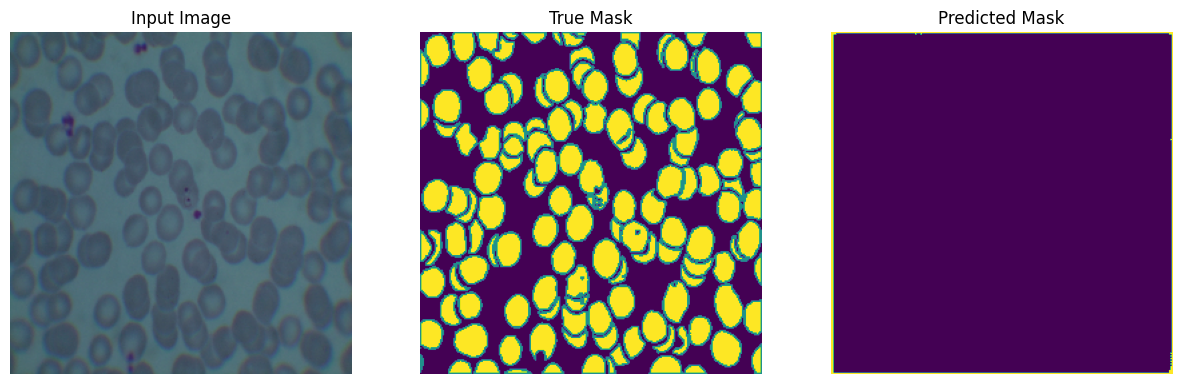

In [9]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ["Input Image", "True Mask", "Predicted Mask"]
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        #plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()

def create_mask(pred_mask):
    #print(pred_mask)
#     pred_mask = tf.argmax(pred_mask, axis=-1)
#     pred_mask = pred_mask[..., tf.newaxis]
#     return pred_mask
    #pred_mask2 = pred_mask.copy()
    pred_mask2 = cv2.cvtColor(pred_mask, cv2.COLOR_BGR2GRAY)
    pred_mask2[pred_mask2 < 0.3] = 0
    pred_mask2[np.logical_and(pred_mask2 >= 0.3, pred_mask2 <= 0.8)] = 1
    pred_mask2[pred_mask2 > 0.8] = 2
    pred_mask2 = pred_mask2.astype(int)
    return pred_mask2
    
## Dataset for prediction
p_image, p_mask = train_gen.__getitem__(0); #accessed as normalised bool
pred_mask = unet_model.predict(p_image)
display([p_image[0], p_mask[0], create_mask(pred_mask[0])])